# Clustering Analysis

This notebook explores unsupervised learning through clustering techniques, focusing on the application of K-Means and DBSCAN algorithms. Clustering is used to discover natural groupings in data without pre-defined labels.



## 1. Introduction to Clustering <a name="introduction"></a>

Clustering is an unsupervised machine learning technique that groups similar data points together based on their intrinsic properties. Unlike supervised learning, clustering doesn't use labeled data for training.

Key clustering applications include:
- Customer segmentation in marketing
- Anomaly detection in security
- Document categorization
- Image segmentation
- Pattern recognition

This notebook focuses on two popular clustering algorithms:
1. **K-Means**: A centroid-based algorithm that partitions data into K clusters
2. **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise): A density-based algorithm that can discover clusters of arbitrary shapes and identify outliers

Let's begin by importing the necessary libraries:

In [1]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, confusion_matrix, adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import time

# For reproducibility
np.random.seed(42)

# Set plot styling
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('default')
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3

sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Dataset Preparation <a name="dataset"></a>

For this analysis, we'll use the MNIST dataset, which contains 70,000 grayscale images of handwritten digits (0-9). Each image is 28x28 pixels, represented as a 784-dimensional vector.

In [2]:
# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{pd.Series(y).value_counts().sort_index()}")

Loading MNIST dataset...
Dataset shape: (70000, 784)
Target distribution:
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64
Dataset shape: (70000, 784)
Target distribution:
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64


In [3]:
# Create directory for saving results if it doesn't exist
os.makedirs('./data', exist_ok=True)

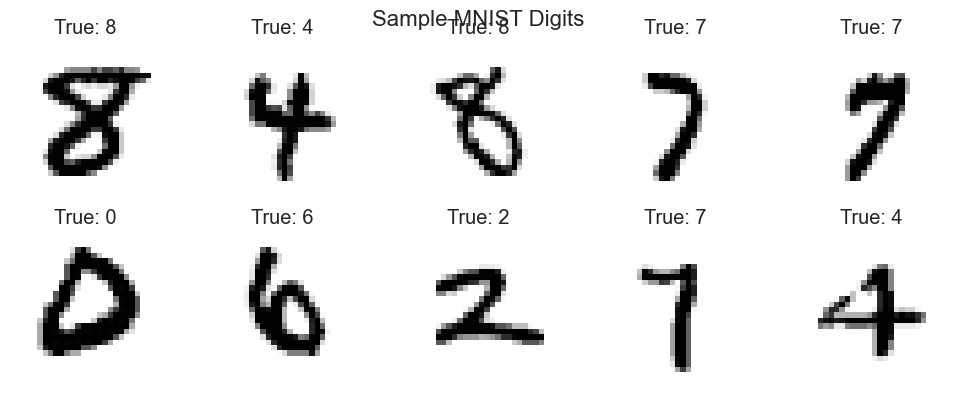

In [4]:
# Define function to display digits
def display_digits(X, y=None, indices=None, predictions=None, title='', n_rows=2, n_cols=5):
    """Display digit images with optional labels and predictions"""
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    axes = axes.flatten()
    
    if indices is None:
        indices = np.random.choice(len(X), size=n_rows*n_cols, replace=False)
    
    for i, ax in enumerate(axes):
        if i < len(indices):
            idx = indices[i]
            img = X[idx].reshape(28, 28)
            ax.imshow(img, cmap='binary')
            
            # Display true label if available
            if y is not None:
                title_str = f"True: {y[idx]}"
                # Add prediction if available
                if predictions is not None:
                    title_str += f"\nPred: {predictions[idx]}"
                ax.set_title(title_str)
            
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return fig

# Display sample digits
fig = display_digits(X, y, indices=np.random.choice(len(X), size=10, replace=False), title='Sample MNIST Digits')
plt.savefig('./data/sample_digits.png', dpi=300, bbox_inches='tight')
plt.show()

Working with the entire MNIST dataset can be computationally intensive, especially for exploratory analysis. Let's create a subset for our initial experiments.

In [5]:
# Create a subset for initial exploration
n_samples = 10000
X_subset = X[:n_samples]
y_subset = y[:n_samples]

print(f"Subset shape: {X_subset.shape}")
print(f"Subset target distribution:\n{pd.Series(y_subset).value_counts().sort_index()}")

Subset shape: (10000, 784)
Subset target distribution:
0    1001
1    1127
2     991
3    1032
4     980
5     863
6    1014
7    1070
8     944
9     978
Name: count, dtype: int64


The MNIST data has 784 dimensions (28x28 pixels), which is quite high for clustering visualization. Let's use PCA to reduce the dimensionality to 2D for visualization purposes.

Explained variance ratio: [0.10200027 0.0721544 ]
Total explained variance: 0.1742


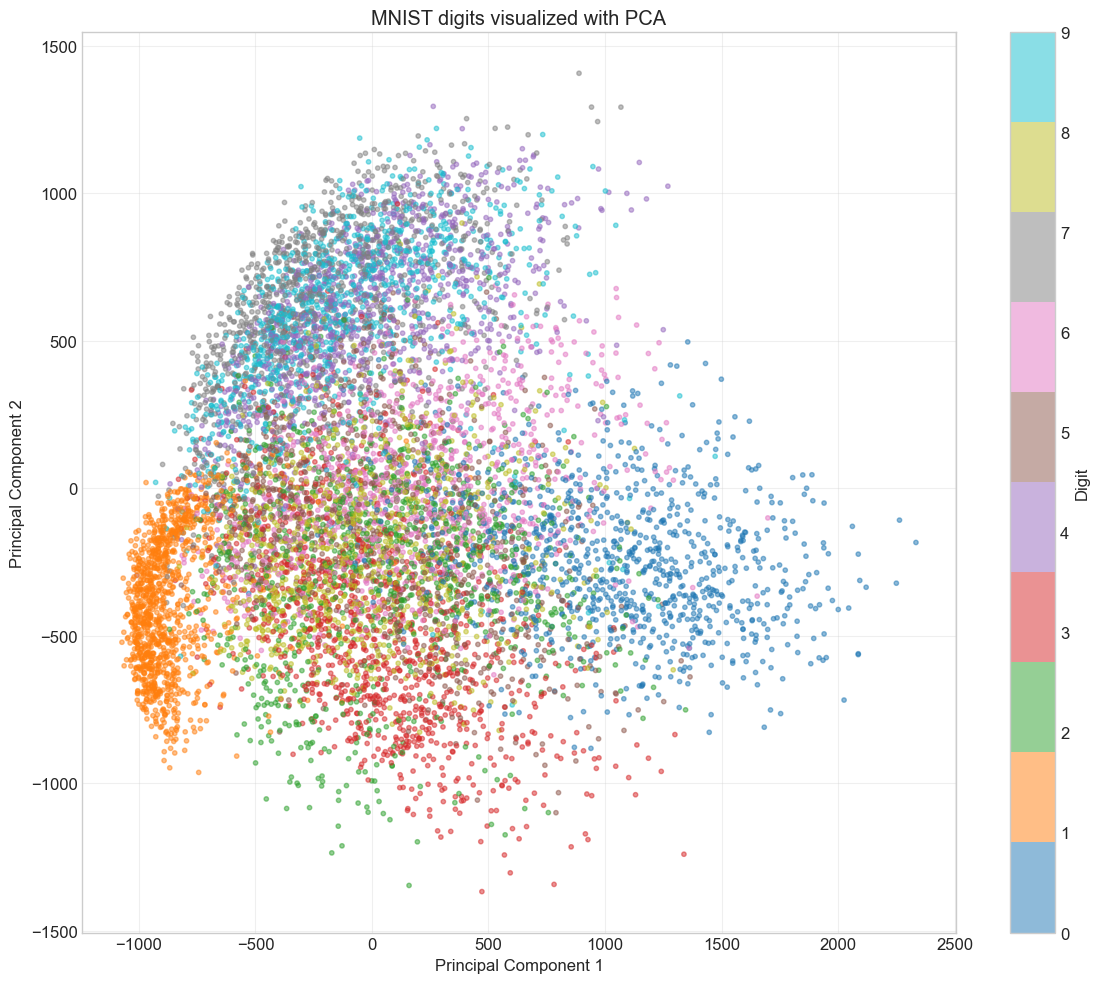

In [6]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_subset)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Plot the data in 2D
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset, cmap='tab10', alpha=0.5, s=10)
plt.colorbar(scatter, label='Digit')
plt.title('MNIST digits visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(alpha=0.3)
plt.savefig('./data/mnist_pca.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Since PCA might not capture the non-linear structure well, let's also try t-SNE for visualization:

Computing t-SNE projection (this may take a while)...
t-SNE completed in 15.02 seconds
t-SNE completed in 15.02 seconds


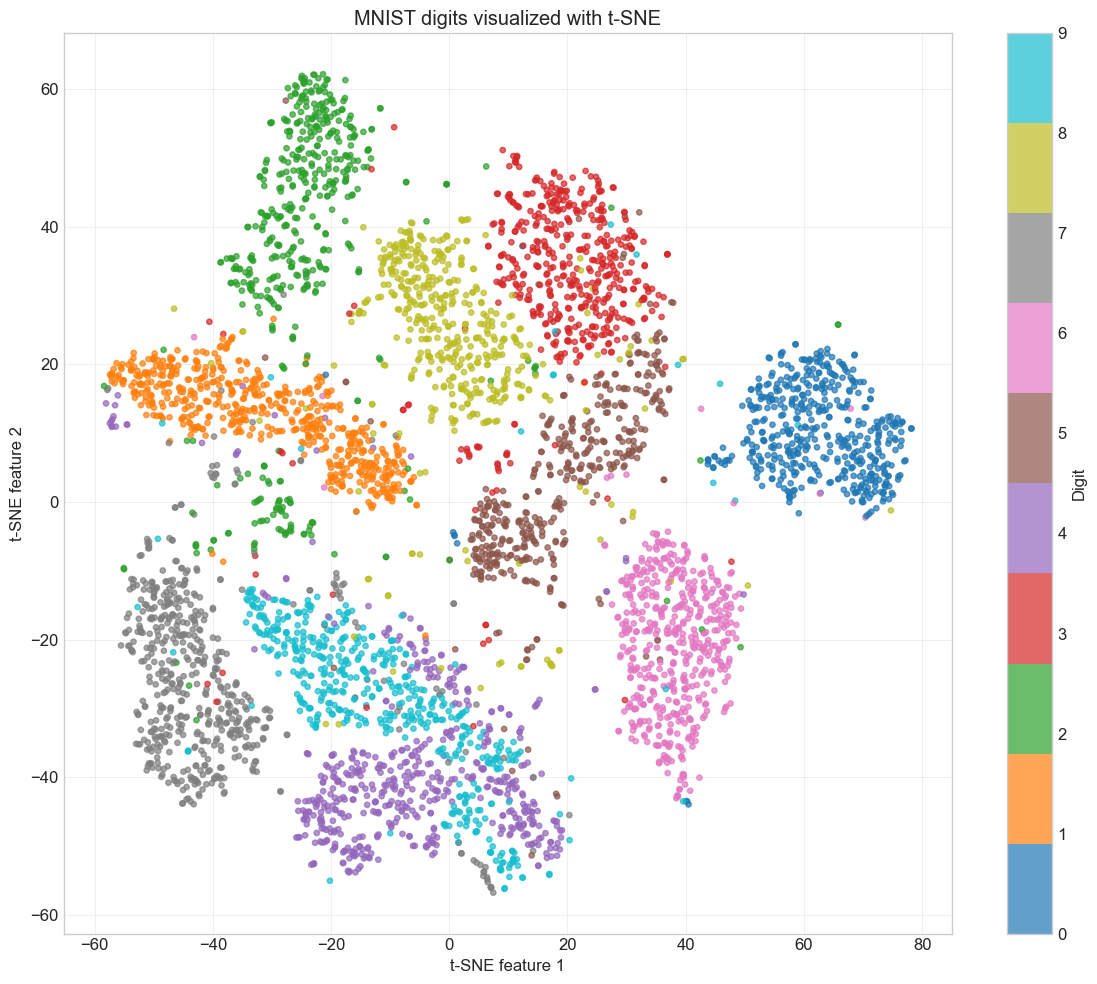

In [7]:
# Apply t-SNE for better visualization of clusters
print("Computing t-SNE projection (this may take a while)...")
time_start = time.time()

# Use a smaller subset for t-SNE due to computational constraints
n_tsne = 5000
X_tsne_subset = X_subset[:n_tsne]
y_tsne_subset = y_subset[:n_tsne]

tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_tsne = tsne.fit_transform(X_tsne_subset)
print(f"t-SNE completed in {time.time() - time_start:.2f} seconds")

# Plot t-SNE visualization
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne_subset, cmap='tab10', alpha=0.7, s=15)
plt.colorbar(scatter, label='Digit')
plt.title('MNIST digits visualized with t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.grid(alpha=0.3)
plt.savefig('./data/mnist_tsne.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## 3. K-Means Clustering <a name="kmeans"></a>

### 3.1 Algorithm Overview <a name="kmeans-overview"></a>

K-Means is one of the most popular clustering algorithms due to its simplicity and efficiency. It works as follows:

1. Initialize K cluster centroids randomly
2. Assign each data point to the nearest centroid
3. Recalculate centroids as the mean of all points assigned to that cluster
4. Repeat steps 2-3 until convergence or maximum iterations reached

K-Means has a few limitations:
- Requires specifying the number of clusters (K) in advance
- Assumes clusters are spherical and of similar size
- Sensitive to outliers and initial centroid placement
- May converge to local optima

Let's apply K-Means to our MNIST subset:

### 3.2 Finding Optimal K <a name="optimal-k"></a>

One of the challenges with K-means is determining the optimal number of clusters (K). We'll use the silhouette score to evaluate different values of K. The silhouette score measures how similar a point is to its own cluster compared to other clusters.

In [8]:
# Evaluate different values of K using silhouette score
k_values = [8, 9, 10, 11, 12]
s_scores = []
kmeans_models = []

print("Evaluating K-means for different values of K...")
for k in k_values:
    print(f"  Evaluating K={k}...")
    best_score = -1
    best_model = None
    # Run multiple times with different initializations
    for _ in range(10): 
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=np.random.randint(0, 1000))
        kmeans.fit(X_subset)
        labels = kmeans.labels_
        score = silhouette_score(X_subset, labels)
        if score > best_score:
            best_score = score
            best_model = kmeans
    
    s_scores.append(best_score)
    kmeans_models.append(best_model)

# Save the silhouette scores
with open('./data/kmeans_sil.pkl', 'wb') as f:
    pickle.dump(s_scores, f)

Evaluating K-means for different values of K...
  Evaluating K=8...
  Evaluating K=9...
  Evaluating K=9...
  Evaluating K=10...
  Evaluating K=10...
  Evaluating K=11...
  Evaluating K=11...
  Evaluating K=12...
  Evaluating K=12...


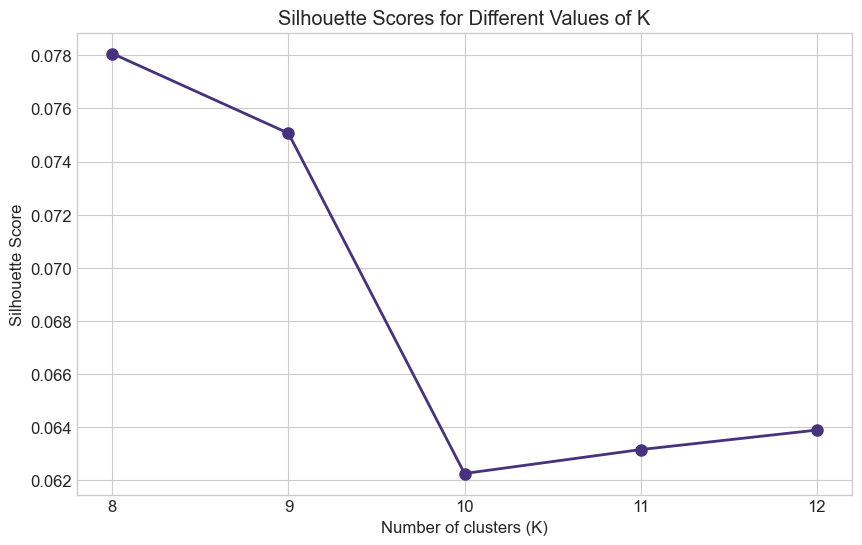

In [9]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, s_scores, 'o-', linewidth=2, markersize=8)
plt.grid(True)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Values of K')
plt.xticks(k_values)
plt.savefig('./data/kmeans_silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Find the best K value
best_k_idx = np.argmax(s_scores)
best_k = k_values[best_k_idx]
best_score = s_scores[best_k_idx]
best_kmeans = kmeans_models[best_k_idx]

print(f"Best number of clusters: {best_k} with silhouette score: {best_score:.4f}")

Best number of clusters: 8 with silhouette score: 0.0781


### 3.3 Cluster Visualization <a name="kmeans-vis"></a>

Let's visualize the clusters found by K-means on our dimensionality-reduced data.

In [11]:
# Apply the best K-means model to the full dataset
print(f"Training K-means with K={best_k} on the full dataset...")
kmeans_full = KMeans(n_clusters=best_k, n_init=10, random_state=42)
kmeans_full.fit(X)
cluster_labels = kmeans_full.labels_

# Display counts for each cluster
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("\nPoints per cluster:")
print(cluster_counts)

Training K-means with K=8 on the full dataset...

Points per cluster:
0    10464
1    12614
2     6739
3     9416
4     8406
5    10759
6     5917
7     5685
Name: count, dtype: int64

Points per cluster:
0    10464
1    12614
2     6739
3     9416
4     8406
5    10759
6     5917
7     5685
Name: count, dtype: int64


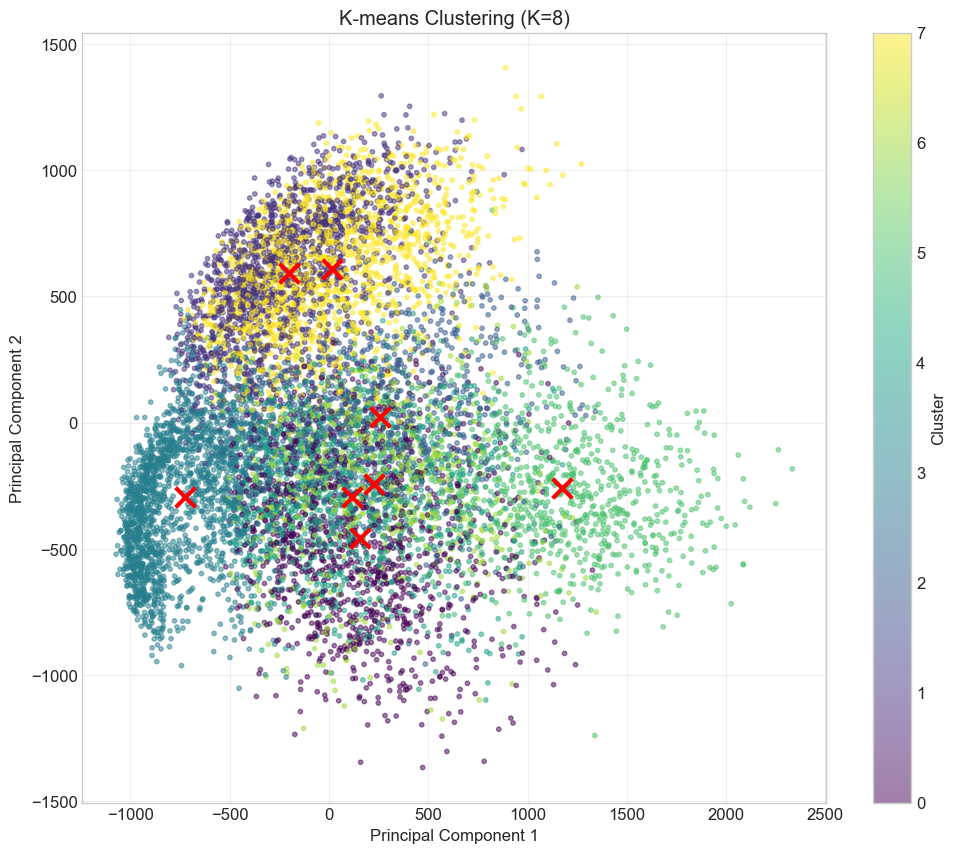

In [12]:
# Visualize the clusters in 2D (PCA)
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_models[best_k_idx].labels_, cmap='viridis', alpha=0.5, s=10)

# Plot centroids
centroids_pca = pca.transform(kmeans_models[best_k_idx].cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', s=200, linewidths=3, color='red', zorder=10)

plt.colorbar(scatter, label='Cluster')
plt.title(f'K-means Clustering (K={best_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(alpha=0.3)
plt.savefig('./data/kmeans_clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.4 Cluster Interpretation <a name="kmeans-interpret"></a>

Let's interpret what each K-means cluster represents. Since we have the ground truth labels for the MNIST dataset, we can analyze how well the clusters correspond to the actual digits.

In [ ]:
# Create a confusion matrix between true labels and cluster assignments
conf_matrix = confusion_matrix(y, cluster_labels)

print(f"Confusion matrix shape: {conf_matrix.shape}")
print(f"Number of true digits: 10")
print(f"Number of clusters (best_k): {best_k}")

n_true_classes = len(np.unique(y)) 
n_clusters = len(np.unique(cluster_labels))  # This is the actual number of clusters

print(f"Actual number of clusters found: {n_clusters}")

# Create confusion matrix with correct dimensions
conf_matrix = confusion_matrix(y, cluster_labels)


In [14]:
# Find the most common digit in each cluster
dominant_digits = np.argmax(conf_matrix, axis=0)
print("Dominant digit in each cluster:")
for cluster, digit in enumerate(dominant_digits):
    count = conf_matrix[digit, cluster]
    total = conf_matrix[:, cluster].sum()
    percentage = count / total * 100
    print(f"Cluster {cluster}: Digit {digit} ({percentage:.2f}%)")

# Save the argmax results
argmax = [np.argmax(row) for row in conf_matrix]
sort_argmax = sorted(set(argmax))

with open('./data/kmeans_argmax.pkl', 'wb') as f:
    pickle.dump(sort_argmax, f)

Dominant digit in each cluster:
Cluster 0: Digit 7 (42.37%)
Cluster 1: Digit 1 (61.37%)
Cluster 2: Digit 6 (85.21%)
Cluster 3: Digit 3 (50.11%)
Cluster 4: Digit 8 (43.58%)
Cluster 5: Digit 4 (35.11%)
Cluster 6: Digit 0 (93.26%)
Cluster 7: Digit 2 (86.47%)
Cluster 8: Digit 0 (nan%)
Cluster 9: Digit 0 (nan%)


C:\Users\kniko\AppData\Local\Temp\ipykernel_13244\1591953676.py:7: RuntimeWarning: invalid value encountered in scalar divide
  percentage = count / total * 100


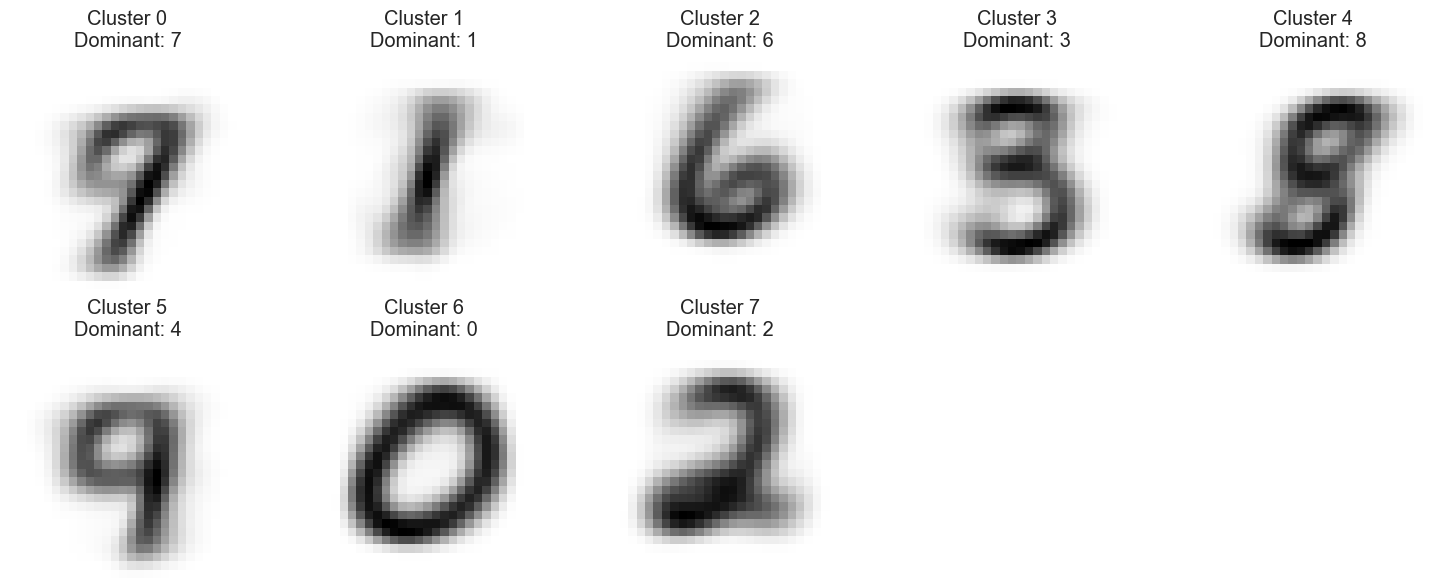

In [15]:
# Visualize cluster centers as digit images
fig = plt.figure(figsize=(15, 6))
for i in range(best_k):
    ax = fig.add_subplot(2, 5, i + 1)
    center_image = kmeans_full.cluster_centers_[i].reshape(28, 28)
    ax.imshow(center_image, cmap='binary')
    ax.set_title(f"Cluster {i}\nDominant: {dominant_digits[i]}")
    ax.axis('off')
plt.tight_layout()
plt.savefig('./data/kmeans_centroids.png', dpi=300, bbox_inches='tight')
plt.show()

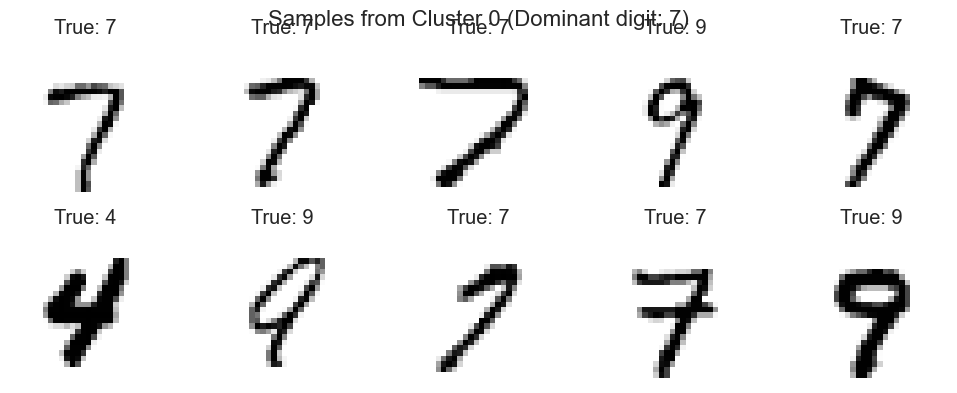

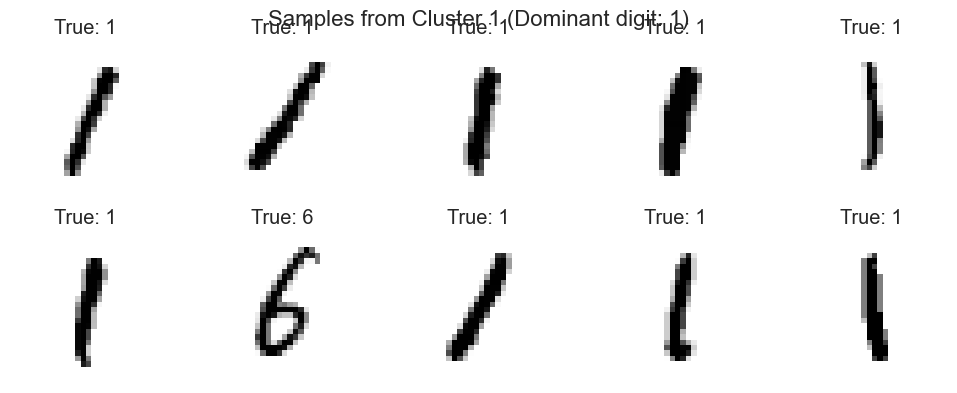

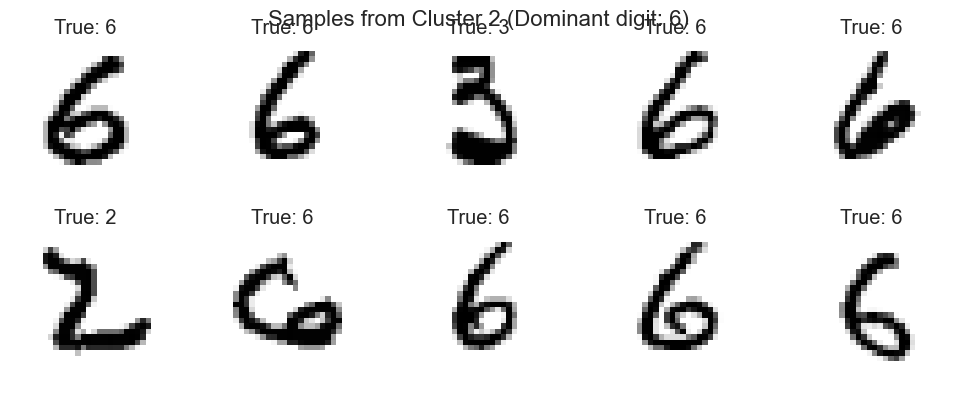

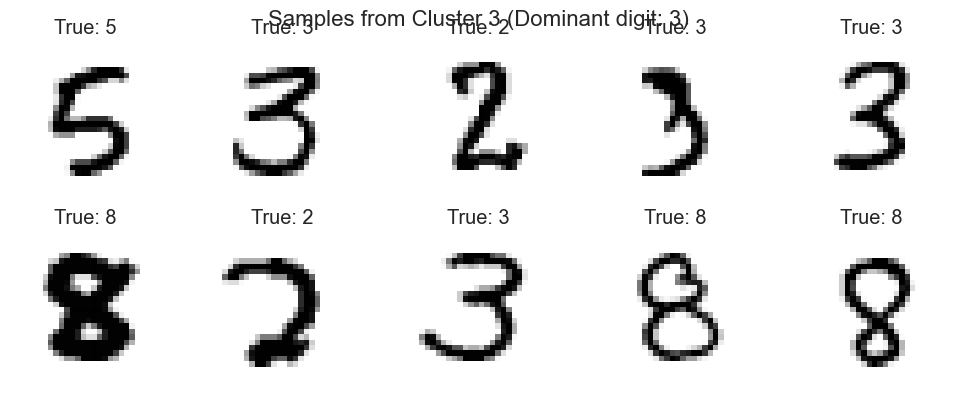

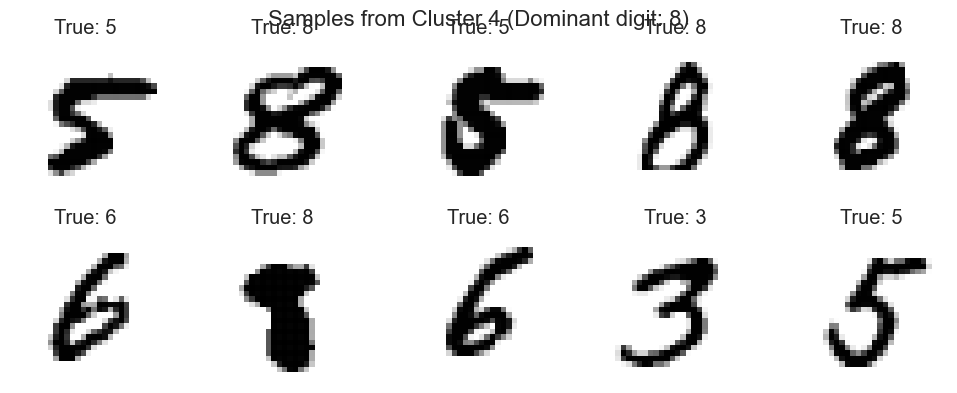

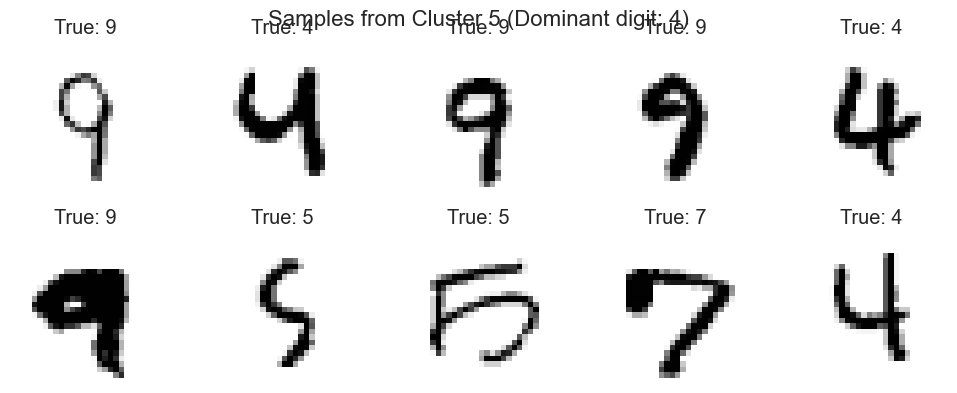

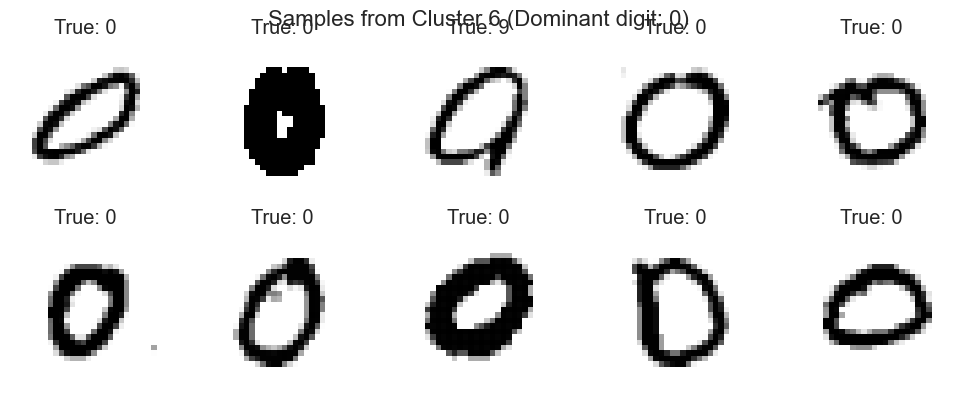

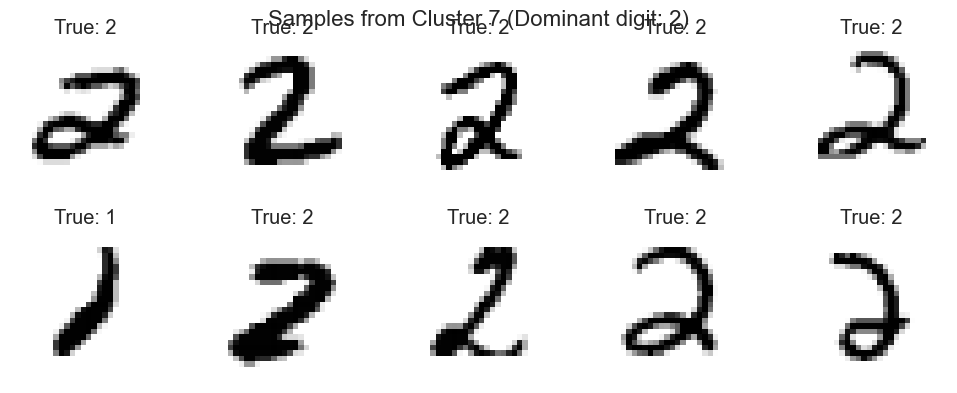

In [16]:
# For each cluster, display some random samples
for cluster_id in range(best_k):
    cluster_samples = np.where(cluster_labels == cluster_id)[0]
    sample_indices = np.random.choice(cluster_samples, size=10, replace=False)
    
    fig = display_digits(X, y, indices=sample_indices, 
                    title=f'Samples from Cluster {cluster_id} (Dominant digit: {dominant_digits[cluster_id]})')
    plt.savefig(f'./data/cluster_{cluster_id}_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. DBSCAN Clustering <a name="dbscan"></a>

### 4.1 Algorithm Overview <a name="dbscan-overview"></a>

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that can find clusters of arbitrary shapes and identify outliers as noise points.

Key components of DBSCAN:

1. **Core points**: Points that have at least `min_samples` points within a distance `eps`
2. **Border points**: Points that are within distance `eps` of a core point but have fewer than `min_samples` neighbors
3. **Noise points**: Points that are neither core nor border points

The algorithm connects core points to form clusters and assigns border points to the nearest cluster. Noise points are labeled as outliers.

Advantages of DBSCAN:
- Can discover clusters of arbitrary shapes
- Does not require specifying the number of clusters in advance
- Can identify outliers as noise

Disadvantages:
- Sensitive to parameter settings (`eps` and `min_samples`)
- Struggles with varying density clusters
- Not suitable for high-dimensional data without dimensionality reduction

### 4.2 Parameter Tuning <a name="dbscan-params"></a>

The performance of DBSCAN heavily depends on the parameters `eps` (neighborhood radius) and `min_samples` (minimum points in a neighborhood). Let's analyze the distance distribution to find a suitable value for `eps`:

In [17]:
# Calculate pairwise distances for a subset of data points
print("Calculating sample distances...")
distances = []
sample_size = 300  # Sample size to calculate distances

for i in range(sample_size):
    for j in range(i+1, sample_size):
        dist = np.linalg.norm(X[i] - X[j])
        if dist != 0:
            distances.append(dist)

# Sort distances and take the smallest ones
s_distances = sorted(distances)[:10]
print(f"Smallest distances: {s_distances}")

# Calculate average of smallest distances for eps
s = np.mean(s_distances[:3])
print(f"Average of 3 smallest distances (potential eps value): {s:.4f}")

# Save distances for reference
with open('./data/dist.pkl', 'wb') as f:
    pickle.dump(s_distances, f)

Calculating sample distances...
Smallest distances: [419.583126448145, 524.325280717991, 636.2460215985637, 638.289902787127, 638.4520342202694, 653.3475338592776, 669.5827058698575, 703.4898719953259, 723.5613311945298, 739.4200430066796]
Average of 3 smallest distances (potential eps value): 526.7181
Smallest distances: [419.583126448145, 524.325280717991, 636.2460215985637, 638.289902787127, 638.4520342202694, 653.3475338592776, 669.5827058698575, 703.4898719953259, 723.5613311945298, 739.4200430066796]
Average of 3 smallest distances (potential eps value): 526.7181


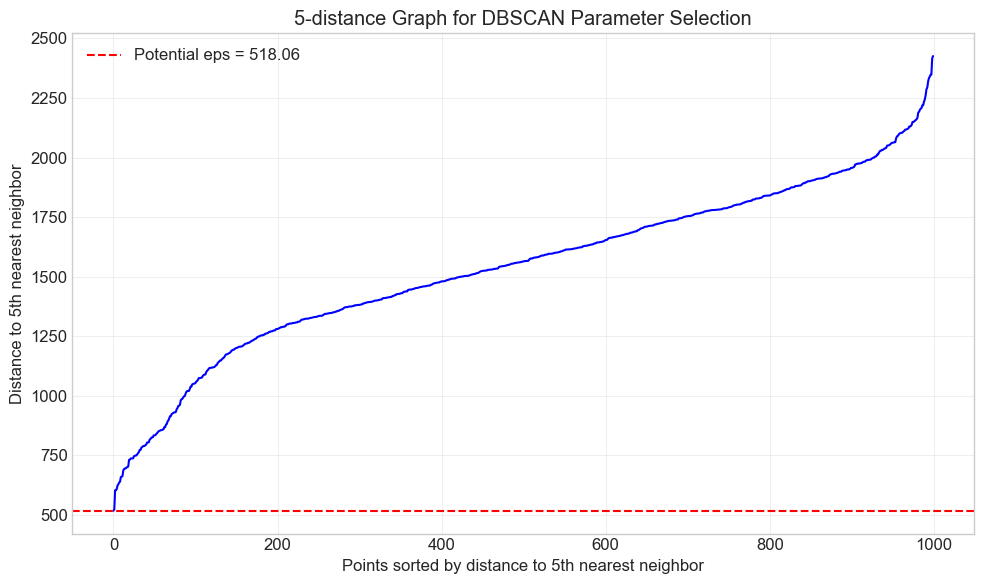

In [18]:
# K-distance graph for a more systematic approach to choosing eps
# Using a smaller subset due to computational constraints
k = 5  # min_samples parameter
n_samples_knn = 1000
X_subset_knn = X[:n_samples_knn]

# Compute the k-nearest neighbor distances
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_subset_knn)
distances, indices = nbrs.kneighbors(X_subset_knn)

# Sort distances to the kth nearest neighbor
k_distances = distances[:, k-1]
k_distances.sort()

# Plot the sorted k-distances
plt.figure(figsize=(10, 6))
plt.plot(k_distances, 'b-')
plt.grid(True, alpha=0.3)
plt.xlabel(f'Points sorted by distance to {k}th nearest neighbor')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.title(f'{k}-distance Graph for DBSCAN Parameter Selection')

# Determine a good eps value based on the elbow of the k-distance graph
# Look for the "elbow" point where the curve starts to rise sharply
elbow_idx = np.argmax(np.diff(np.diff(k_distances)))
elbow_eps = k_distances[elbow_idx]
plt.axhline(y=elbow_eps, color='r', linestyle='--', label=f'Potential eps = {elbow_eps:.2f}')
plt.legend()

plt.savefig('./data/dbscan_k_distance.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [19]:
# Define a range of eps values to test
eps_values = np.arange(s, s + 0.1 * s, 0.04 * s)
print(f"Testing eps values: {eps_values}")

# Define min_samples
min_samples = 5

# Test different eps values and count the number of clusters
dbscan_results = []
dbscan_labels = []

print("Evaluating DBSCAN with different eps values...")
# We'll use a smaller subset for DBSCAN due to computational constraints
X_dbscan = X[:5000]
y_dbscan = y[:5000]

for eps in eps_values:
    print(f"  Evaluating eps={eps:.4f}...")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_dbscan)
    
    # Count unique clusters (excluding noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    dbscan_labels.append(n_clusters)
    dbscan_results.append({
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': n_noise / len(labels),
        'labels': labels
    })

# Save the number of clusters for each eps value
with open('./data/dbscan_len.pkl', 'wb') as f:
    pickle.dump(dbscan_labels, f)

Testing eps values: [526.71814292 547.78686864 568.85559436]
Evaluating DBSCAN with different eps values...
  Evaluating eps=526.7181...
  Evaluating eps=547.7869...
  Evaluating eps=547.7869...
  Evaluating eps=568.8556...
  Evaluating eps=568.8556...


          eps  min_samples  n_clusters  n_noise  noise_ratio
0  526.718143            5          11     4899       0.9798
1  547.786869            5          10     4865       0.9730
2  568.855594            5           9     4831       0.9662


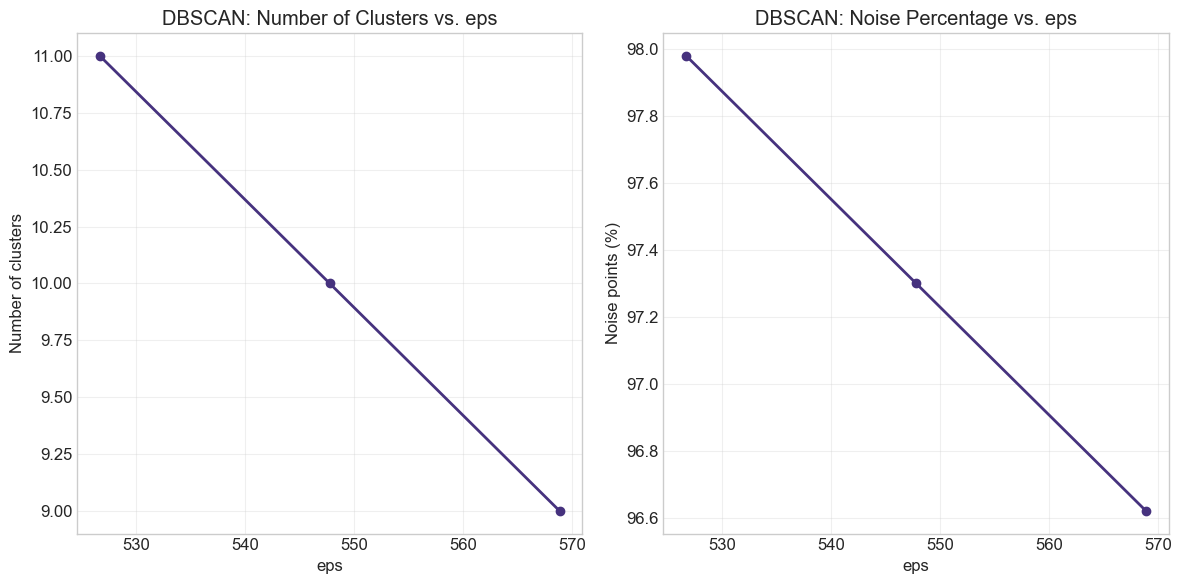

In [20]:
# Create a DataFrame for easier analysis
dbscan_df = pd.DataFrame(dbscan_results)[['eps', 'min_samples', 'n_clusters', 'n_noise', 'noise_ratio']]
print(dbscan_df)

# Plot the number of clusters and noise ratio for different eps values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(dbscan_df['eps'], dbscan_df['n_clusters'], 'o-', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('eps')
plt.ylabel('Number of clusters')
plt.title('DBSCAN: Number of Clusters vs. eps')

plt.subplot(1, 2, 2)
plt.plot(dbscan_df['eps'], dbscan_df['noise_ratio'] * 100, 'o-', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('eps')
plt.ylabel('Noise points (%)')
plt.title('DBSCAN: Noise Percentage vs. eps')

plt.tight_layout()
plt.savefig('./data/dbscan_parameters.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.3 Cluster Visualization <a name="dbscan-vis"></a>

Let's select the best DBSCAN result based on the number of clusters and noise ratio, and visualize the results:

In [21]:
# Choose the best DBSCAN result based on the number of clusters (closest to 10)
target_clusters = 10  # Since we have 10 digits
best_idx = np.argmin(np.abs(np.array(dbscan_df['n_clusters']) - target_clusters))
best_eps = dbscan_df.iloc[best_idx]['eps']
best_n_clusters = dbscan_df.iloc[best_idx]['n_clusters']
best_noise_ratio = dbscan_df.iloc[best_idx]['noise_ratio']
best_dbscan_labels = dbscan_results[best_idx]['labels']

print(f"Best DBSCAN parameters: eps={best_eps:.4f}, min_samples={min_samples}")
print(f"Number of clusters: {best_n_clusters}")
print(f"Noise ratio: {best_noise_ratio:.2%}")

Best DBSCAN parameters: eps=547.7869, min_samples=5
Number of clusters: 10.0
Noise ratio: 97.30%


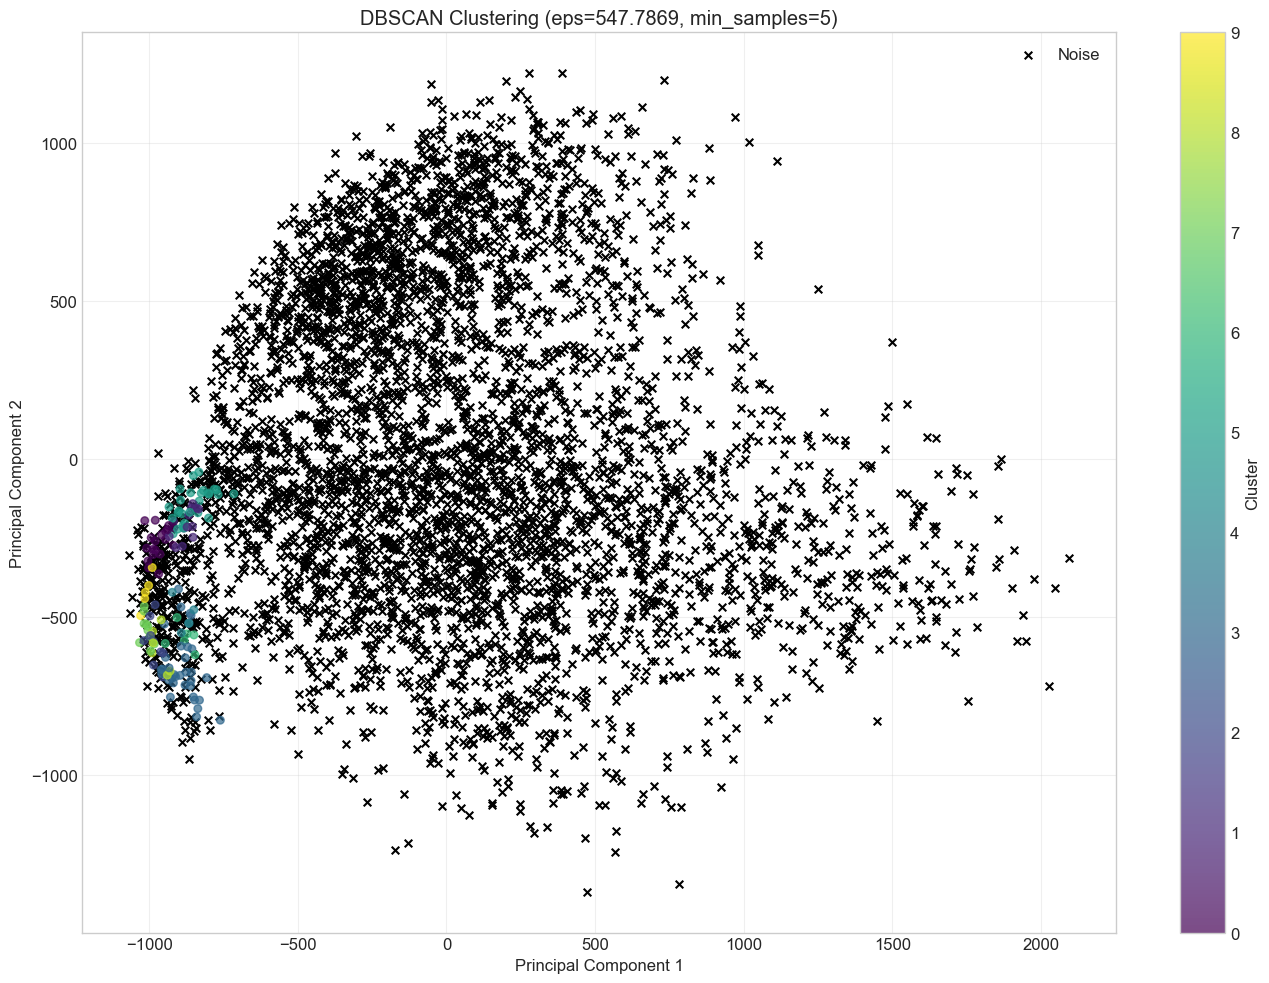

In [22]:
# Prepare data for visualization
X_pca_dbscan = pca.transform(X_dbscan)

# Visualize DBSCAN clusters
plt.figure(figsize=(14, 10))

# Plot noise points in black
noise_mask = (best_dbscan_labels == -1)
plt.scatter(X_pca_dbscan[noise_mask, 0], X_pca_dbscan[noise_mask, 1], 
            color='black', marker='x', s=30, label='Noise')

# Plot clusters with different colors
cluster_mask = ~noise_mask
plt.scatter(X_pca_dbscan[cluster_mask, 0], X_pca_dbscan[cluster_mask, 1], 
            c=best_dbscan_labels[cluster_mask], cmap='viridis', 
            s=30, alpha=0.7)

plt.title(f'DBSCAN Clustering (eps={best_eps:.4f}, min_samples={min_samples})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(alpha=0.3)
plt.colorbar(label='Cluster')
plt.legend()
plt.savefig('./data/dbscan_clusters_pca.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

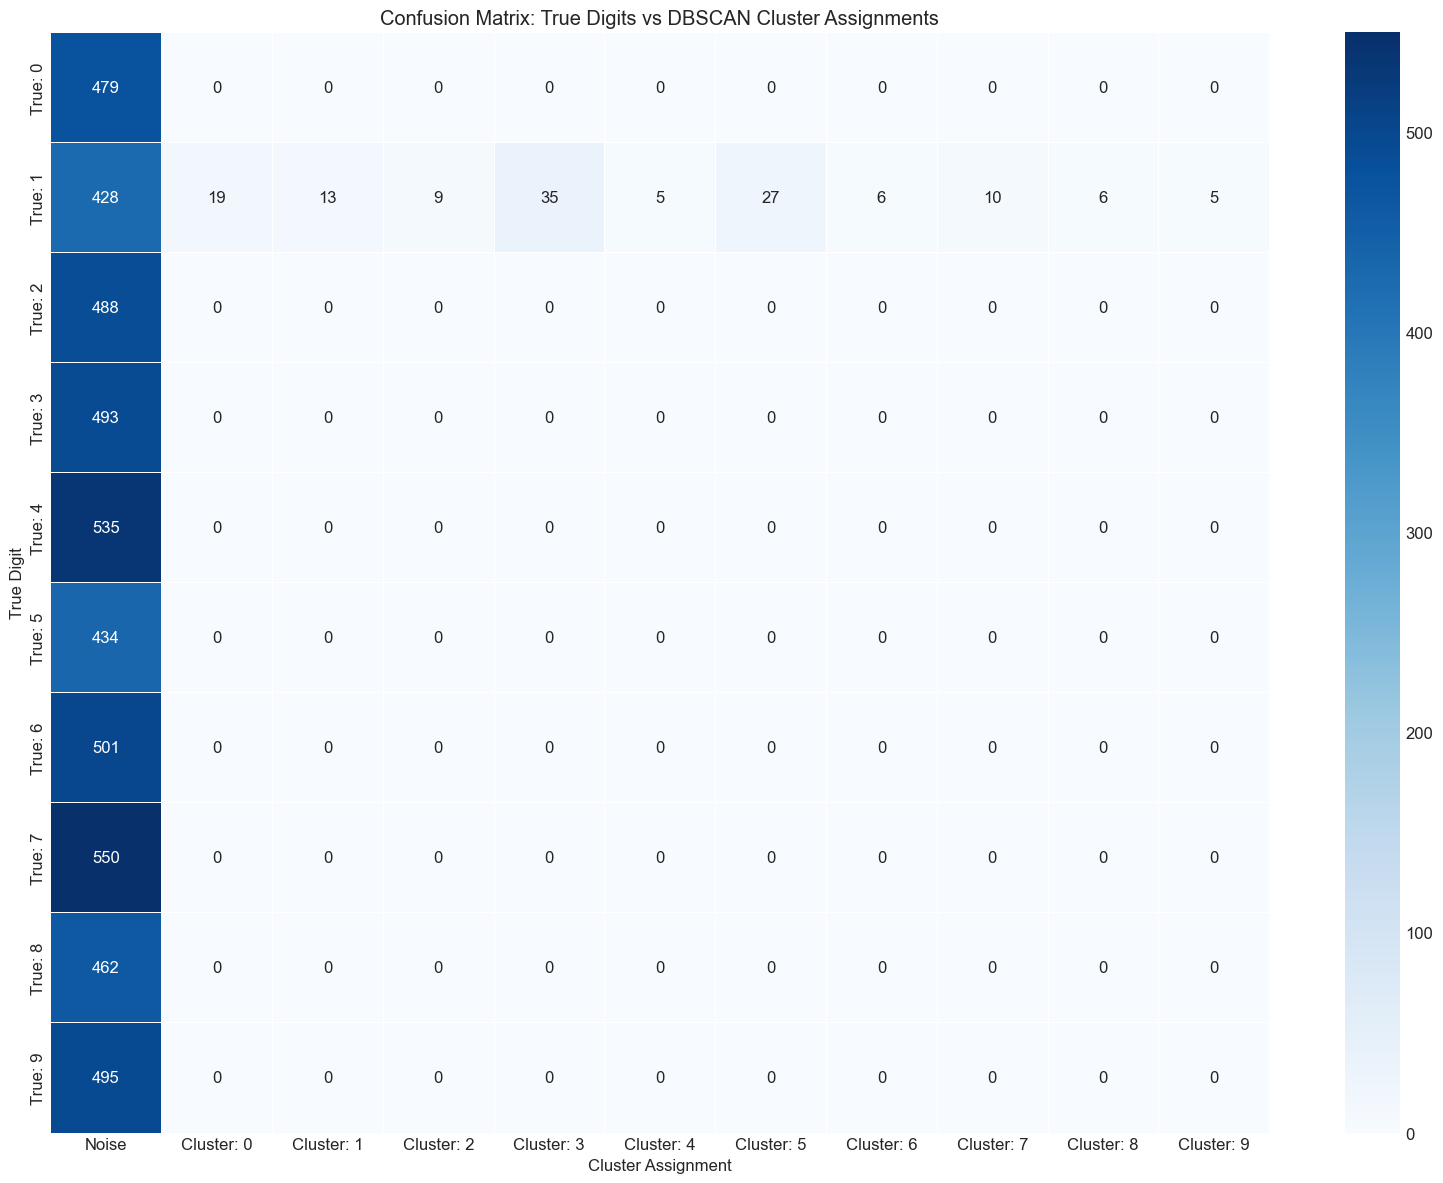

In [23]:
# Create a confusion matrix between true labels and DBSCAN cluster assignments
# We need to handle noise points (-1 label) specially by adding an extra row
cluster_range = range(-1, max(best_dbscan_labels) + 1)
dbscan_conf_matrix = np.zeros((10, len(cluster_range)), dtype=int)

for true_digit, cluster in zip(y_dbscan, best_dbscan_labels):
    dbscan_conf_matrix[true_digit, cluster + 1] += 1  # +1 to handle -1 noise cluster

# Convert to DataFrame for better visualization
dbscan_conf_df = pd.DataFrame(
    dbscan_conf_matrix, 
    index=[f'True: {i}' for i in range(10)],
    columns=[f'Noise' if i == -1 else f'Cluster: {i}' for i in cluster_range]
)

# Visualize the confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(dbscan_conf_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Confusion Matrix: True Digits vs DBSCAN Cluster Assignments')
plt.ylabel('True Digit')
plt.xlabel('Cluster Assignment')
plt.tight_layout()
plt.savefig('./data/dbscan_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.4 Outlier Detection <a name="dbscan-outliers"></a>

One of the key features of DBSCAN is its ability to identify outliers (noise points). Let's examine the noise points detected by DBSCAN:

Number of noise points: 4865 (97.30%)


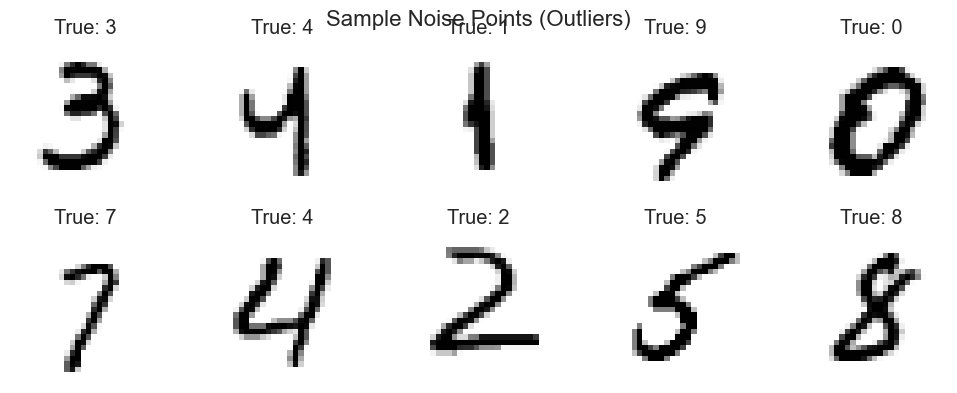

In [24]:
# Identify noise points
noise_indices = np.where(best_dbscan_labels == -1)[0]
print(f"Number of noise points: {len(noise_indices)} ({len(noise_indices)/len(best_dbscan_labels):.2%})")

# Display some noise points
sample_noise = np.random.choice(noise_indices, size=min(10, len(noise_indices)), replace=False)
fig = display_digits(X_dbscan, y_dbscan, indices=sample_noise, title='Sample Noise Points (Outliers)')
plt.savefig('./data/dbscan_noise_samples.png', dpi=300, bbox_inches='tight')
plt.show()

   Digit  Noise Count  Noise Percentage
0      0          479        100.000000
1      1          428         76.021314
2      2          488        100.000000
3      3          493        100.000000
4      4          535        100.000000
5      5          434        100.000000
6      6          501        100.000000
7      7          550        100.000000
8      8          462        100.000000
9      9          495        100.000000


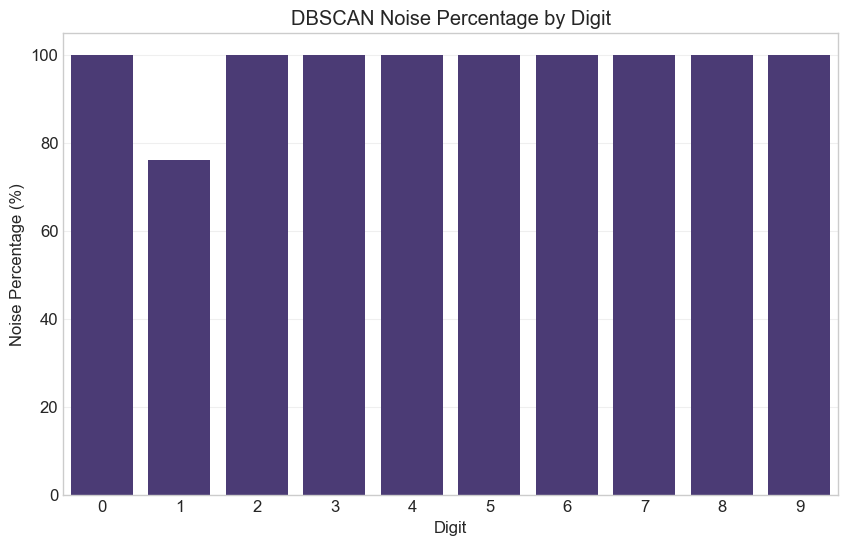

In [25]:
# Analyze noise points by digit class
noise_by_digit = {}
for i in range(10):
    digit_indices = np.where(y_dbscan == i)[0]
    noise_count = np.sum(best_dbscan_labels[digit_indices] == -1)
    noise_by_digit[i] = (noise_count, noise_count / len(digit_indices))

# Create a DataFrame for better visualization
noise_df = pd.DataFrame({
    'Digit': range(10),
    'Noise Count': [noise_by_digit[i][0] for i in range(10)],
    'Noise Percentage': [noise_by_digit[i][1] * 100 for i in range(10)]
})

print(noise_df)

# Plot noise percentage by digit
plt.figure(figsize=(10, 6))
sns.barplot(x='Digit', y='Noise Percentage', data=noise_df)
plt.title('DBSCAN Noise Percentage by Digit')
plt.xlabel('Digit')
plt.ylabel('Noise Percentage (%)')
plt.grid(axis='y', alpha=0.3)
plt.savefig('./data/dbscan_noise_by_digit.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Comparing Clustering Methods <a name="comparison"></a>

Now that we've applied both K-Means and DBSCAN to our dataset, let's compare their performance.

In [26]:
# Since DBSCAN was applied to a subset, let's use that subset for comparison
kmeans_subset = KMeans(n_clusters=best_k, n_init=10, random_state=42)
kmeans_subset.fit(X_dbscan)
kmeans_subset_labels = kmeans_subset.labels_

# Calculate adjusted Rand index for both methods
# The adjusted Rand index measures the similarity between two clusterings
# It ranges from -1 to 1, where 1 means perfect agreement
kmeans_ari = adjusted_rand_score(y_dbscan, kmeans_subset_labels)

# For DBSCAN, we need to handle noise points
# Option 1: Exclude noise points
non_noise_mask = (best_dbscan_labels != -1)
dbscan_ari_without_noise = adjusted_rand_score(
    y_dbscan[non_noise_mask], 
    best_dbscan_labels[non_noise_mask]
)

# Option 2: Treat each noise point as its own cluster
dbscan_ari_with_noise = adjusted_rand_score(y_dbscan, best_dbscan_labels)

print(f"K-means Adjusted Rand Index: {kmeans_ari:.4f}")
print(f"DBSCAN Adjusted Rand Index (excluding noise): {dbscan_ari_without_noise:.4f}")
print(f"DBSCAN Adjusted Rand Index (including noise): {dbscan_ari_with_noise:.4f}")

K-means Adjusted Rand Index: 0.3688
DBSCAN Adjusted Rand Index (excluding noise): 0.0000
DBSCAN Adjusted Rand Index (including noise): 0.0002


In [27]:
# Calculate silhouette scores for both methods
kmeans_silhouette = silhouette_score(X_dbscan, kmeans_subset_labels)

# For DBSCAN, we need to exclude noise points for silhouette score
if np.sum(non_noise_mask) > 1:  # Check if there are at least 2 non-noise points
    dbscan_silhouette = silhouette_score(
        X_dbscan[non_noise_mask], 
        best_dbscan_labels[non_noise_mask]
    )
else:
    dbscan_silhouette = np.nan

print(f"K-means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette:.4f}")

K-means Silhouette Score: 0.0780
DBSCAN Silhouette Score (excluding noise): 0.2142


In [28]:
# Compare the number of clusters and other metrics
comparison_data = {
    'Method': ['K-means', 'DBSCAN'],
    'Number of Clusters': [best_k, best_n_clusters],
    'Adjusted Rand Index': [kmeans_ari, dbscan_ari_with_noise],
    'Silhouette Score': [kmeans_silhouette, dbscan_silhouette],
    'Outliers Detected': [0, np.sum(best_dbscan_labels == -1)],
    'Outlier Percentage': [0, best_noise_ratio * 100]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Method,Number of Clusters,Adjusted Rand Index,Silhouette Score,Outliers Detected,Outlier Percentage
0,K-means,8.0,0.368780,0.078045,0,0.0
1,DBSCAN,10.0,0.000225,0.214156,4865,97.3


## 6. Advanced Clustering Applications <a name="applications"></a>

Beyond basic clustering, let's explore some advanced applications of these techniques:

Applying hierarchical clustering...


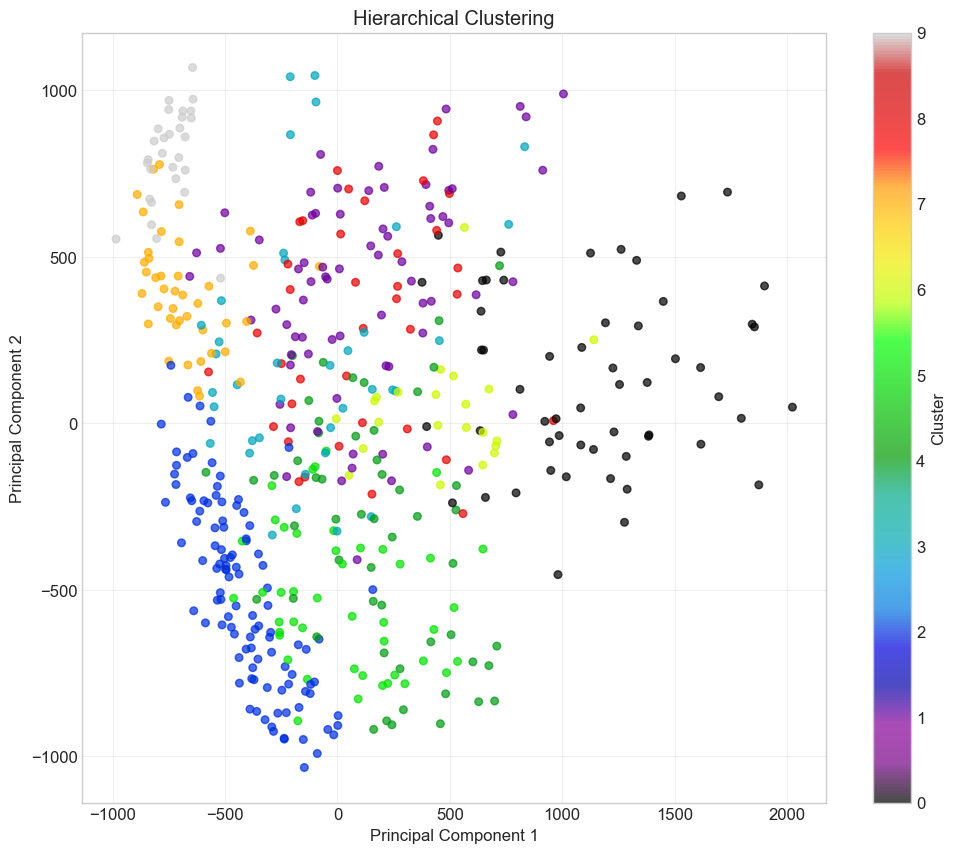

In [29]:
# Hierarchical clustering for a different perspective
# This can be computationally expensive, so we'll use a very small subset
n_hier = 500
X_hier = X[:n_hier]
y_hier = y[:n_hier]

print("Applying hierarchical clustering...")
agglom = AgglomerativeClustering(n_clusters=10, linkage='ward')
hier_labels = agglom.fit_predict(X_hier)

# Apply PCA for visualization
X_hier_pca = PCA(n_components=2).fit_transform(X_hier)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_hier_pca[:, 0], X_hier_pca[:, 1], c=hier_labels, cmap='nipy_spectral', alpha=0.7, s=30)
plt.colorbar(scatter, label='Cluster')
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(alpha=0.3)
plt.savefig('./data/hierarchical_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

Number of anomalies detected: 5000 (100.00%)


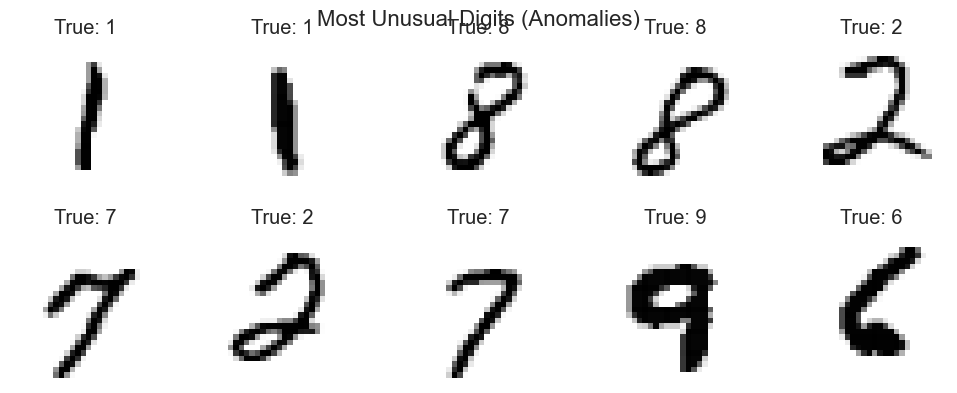

In [30]:
# Example: Using clustering for anomaly detection
# Let's use DBSCAN to find the most unusual digits in our dataset

# Train DBSCAN with stricter parameters to find more outliers
strict_dbscan = DBSCAN(eps=best_eps*0.7, min_samples=min_samples+2)
strict_labels = strict_dbscan.fit_predict(X_dbscan)

# Count noise points
strict_noise_indices = np.where(strict_labels == -1)[0]
print(f"Number of anomalies detected: {len(strict_noise_indices)} ({len(strict_noise_indices)/len(strict_labels):.2%})")

# Display some of the most unusual digits
if len(strict_noise_indices) > 0:
    sample_anomalies = np.random.choice(strict_noise_indices, size=min(10, len(strict_noise_indices)), replace=False)
    fig = display_digits(X_dbscan, y_dbscan, indices=sample_anomalies, title='Most Unusual Digits (Anomalies)')
    plt.savefig('./data/anomaly_digits.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Conclusion <a name="conclusion"></a>

In this notebook, we explored clustering techniques for unsupervised learning using the MNIST dataset:

### K-Means Clustering
- We found the optimal number of clusters (K) using silhouette scores
- Each cluster corresponded reasonably well to specific digit classes
- The algorithm successfully identified centroids that represent prototypical digit patterns
- K-means requires specifying K in advance and tends to create spherical clusters

### DBSCAN Clustering
- We determined appropriate parameters (eps and min_samples) by analyzing distance distributions
- DBSCAN identified clusters of varying shapes and densities
- A key advantage was the ability to identify outliers/anomalies
- The algorithm struggled with the high dimensionality of the data

### Comparative Analysis
- K-means generally performed better according to silhouette score and adjusted Rand index
- DBSCAN provided additional insights through outlier detection
- Hierarchical clustering showed yet another perspective on the data structure

### Applications and Insights
- Clustering can be used for dimensionality reduction, anomaly detection, and data exploration
- Visualizing high-dimensional data requires techniques like PCA or t-SNE
- The choice of clustering algorithm depends on the specific task and data characteristics

This exploration demonstrates how unsupervised learning can uncover meaningful patterns in data without relying on labels, making it a valuable tool for exploratory data analysis and various applications across domains.